# 1. 简介

- 主页 | https://tsfresh.com/
- 文档 | https://tsfresh.readthedocs.io/en/latest/
- Github | https://github.com/blue-yonder/tsfresh
- Stars | 7.1k
- 协议 | MIT

tsfresh 是一个用于时间序列特征生成的python包。使用tsfresh可以自动计算出大量的时间序列特征，tsfresh还内置有特征筛选算法可以挑选出和任务有关的特征。提取的特征可用于描述时间序列，这些特征可以用于下游的时间序列任务，如股票价格预测、天气预测、景点人流预测、时尚商品销量预测、商品推荐系统等。

tfresh的特点：

- 安装方便，使用简单；
- 内置数百个在各个领域验证有效的特征生成函数可调用；
- 支持设置目标进行特征过滤；
- 支持自定义新的特征函数；
- 支持对滚动时间序列提取特征；
- 支持使用Dask在处理大样本数据；
- 支持进行并行化加速；
- 可以和scikit-learn进行结合使用。

In [2]:
# 如果没有安装，解注释如下代码
# !pip install -U tsfresh

In [4]:
%matplotlib inline

# 引入头文件
import qstock as qs

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

from sklearn.ensemble import AdaBoostRegressor

# 2. 数据获取

本文使用qstock获取历史行情数据：https://github.com/tkfy920/qstock

读者直接在cmd或anaconda prompt上输入“pip install qstock ”进行安装，
或输入“pip install -upgrade qstock”进行更新。

- 历史K线  
  获取单只或多只证券（股票、基金、债券、期货)的历史K线数据。可以根据realtime_data实时行情接口获取相应金融市场交易标的的代码或简称，用于获取其历史K线数据。

    - get_data(code_list, start='19000101', end=None, freq='d', fqt=1)

   
   获取股票、指数、债券、期货、基金等历史K线行情。参数说明：

    - code_list输入股票list列表，如code_list=['中国平安','贵州茅台','工业富联'] ，返回多只股票多期时间的面板数据
    - start和end为起始和结束日期，年月日
    - freq:时间频率，默认日，1 : 分钟；5 : 5 分钟；15 : 15 分钟；30 : 30 分钟； 60 : 60 分钟；101或'D'或'd'：日；102或‘w’或'W'：周; 103或'm'或'M': 月 注意1分钟只能获取最近5个交易日一分钟数据
    - fqt:复权类型，0：不复权，1：前复权；2：后复权，默认前复权

In [28]:
code_list=['中国平安']  # 股票列表
df = qs.get_data(code_list, start='20220101', end='20230226', freq='d', fqt=2)
print(df.head())
print('shape: ', df.shape)

100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

            name    code    open    high     low   close   volume  \
date                                                                
2022-01-04  中国平安  601318  124.83  126.15  124.23  126.03   635838   
2022-01-05  中国平安  601318  126.25  128.83  125.97  128.17  1181247   
2022-01-06  中国平安  601318  128.01  128.07  126.47  126.63   661658   
2022-01-07  中国平安  601318  127.01  130.69  126.93  129.91  1230760   
2022-01-10  中国平安  601318  130.01  131.15  129.03  130.19   761134   

                turnover  turnover_rate  
date                                     
2022-01-04  3.221367e+09           0.59  
2022-01-05  6.124174e+09           1.09  
2022-01-06  3.408948e+09           0.61  
2022-01-07  6.481039e+09           1.14  
2022-01-10  4.033301e+09           0.70  
shape:  (276, 9)


# 3. 数据处理

In [29]:
df.drop(columns=['code'], inplace=True)  # 删除股票代码code列, inplace为直接修改df，否则需要赋值给新的变量
# fixme:由于index列无法获取或指定列名（也许可以实现，但试了好几种方法都报错），新生成一列作为时间，把index的时间赋值这一列
df['time'] = df.index
# 滚动处理时间序列，指定id列和时间列，滚动处理时序数据
df_rolled = roll_time_series(df, column_id="name", column_sort="time",
                             max_timeshift=20, min_timeshift=5)
print(df_rolled.head())
print('shape: ', df_rolled.shape)

D:\ProgramFiles\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(

Rolling: 100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


   name    open    high     low   close   volume      turnover  turnover_rate  \
0  中国平安  124.83  126.15  124.23  126.03   635838  3.221367e+09           0.59   
1  中国平安  126.25  128.83  125.97  128.17  1181247  6.124174e+09           1.09   
2  中国平安  128.01  128.07  126.47  126.63   661658  3.408948e+09           0.61   
3  中国平安  127.01  130.69  126.93  129.91  1230760  6.481039e+09           1.14   
4  中国平安  130.01  131.15  129.03  130.19   761134  4.033301e+09           0.70   

        time                           id  
0 2022-01-04  (中国平安, 2022-01-11 00:00:00)  
1 2022-01-05  (中国平安, 2022-01-11 00:00:00)  
2 2022-01-06  (中国平安, 2022-01-11 00:00:00)  
3 2022-01-07  (中国平安, 2022-01-11 00:00:00)  
4 2022-01-10  (中国平安, 2022-01-11 00:00:00)  
shape:  (5571, 10)


In [30]:
# name为股票名的列，不作为特征，所以删除
df_rolled.drop(columns=['name'], inplace=True)  # 删除name列, inplace为直接修改df，否则需要赋值给新的变量
print(df_rolled.head())

     open    high     low   close   volume      turnover  turnover_rate  \
0  124.83  126.15  124.23  126.03   635838  3.221367e+09           0.59   
1  126.25  128.83  125.97  128.17  1181247  6.124174e+09           1.09   
2  128.01  128.07  126.47  126.63   661658  3.408948e+09           0.61   
3  127.01  130.69  126.93  129.91  1230760  6.481039e+09           1.14   
4  130.01  131.15  129.03  130.19   761134  4.033301e+09           0.70   

        time                           id  
0 2022-01-04  (中国平安, 2022-01-11 00:00:00)  
1 2022-01-05  (中国平安, 2022-01-11 00:00:00)  
2 2022-01-06  (中国平安, 2022-01-11 00:00:00)  
3 2022-01-07  (中国平安, 2022-01-11 00:00:00)  
4 2022-01-10  (中国平安, 2022-01-11 00:00:00)  


# 4. 特征工程
## 4.1 特征提取

In [31]:
# 提取特征，可以指定特征列（不指定即所有的列）
X = extract_features(df_rolled, 
                     column_id="id", column_sort="time", # column_value="high", 
                     impute_function=impute)  # , show_warnings=False)
X.head()


100%|██████████| 1/1 [06:42<00:00, 402.38s/it]26<01:45,  4.58s/it]

Feature Extraction: 100%|██████████| 30/30 [00:50<00:00,  1.68s/it]


open__variance_larger_than_standard_deviation  \
中国平安 2022-01-11                                            1.0   
     2022-01-12                                            1.0   
     2022-01-13                                            1.0   
     2022-01-14                                            1.0   
     2022-01-17                                            1.0   

                 open__has_duplicate_max  open__has_duplicate_min  \
中国平安 2022-01-11                      0.0                      0.0   
     2022-01-12                      0.0                      0.0   
     2022-01-13                      0.0                      0.0   
     2022-01-14                      0.0                      0.0   
     2022-01-17                      0.0                      0.0   

                 open__has_duplicate  open__sum_values  open__abs_energy  \
中国平安 2022-01-11                  0.0            766.48        97938.6286   
     2022-01-12                  0.0            895.71       114639.0215   
     2022-01-13                  0.0           1024.84       131313.5784   
     2022-01-14                  0.0           1153.57       147884.9913   
     2022-01-17                  1.0           1279.82       163824.0538   

                 open__mean_abs_change  open__mean_change  \
中国平安 2022-01-11               1.508000           1.108000   
     2022-01-12               1.446667           0.733333   
     2022-01-13               1.254286           0.614286   
     2022-01-14               1.147500           0.487500   
     2022-01-17               1.295556           0.157778   

                 open__mean_second_derivative_central  open__median  ...  \
中国平安 2022-01-11                             -0.132500        127.51  ...   
     2022-01-12                             -0.256000        128.01  ...   
     2022-01-13                             -0.126667        128.57  ...   
     2022-01-14                             -0.130000        128.73  ...   
     2022-01-17                             -0.243750        128.37  ...   

                 turnover_rate__fourier_entropy__bins_5  \
中国平安 2022-01-11                                1.039721   
     2022-01-12                                1.386294   
     2022-01-13                                0.950271   
     2022-01-14                                0.950271   
     2022-01-17                                1.329661   

                 turnover_rate__fourier_entropy__bins_10  \
中国平安 2022-01-11                                 1.386294   
     2022-01-12                                 1.386294   
     2022-01-13                                 1.332179   
     2022-01-14                                 0.950271   
     2022-01-17                                 1.329661   

                 turnover_rate__fourier_entropy__bins_100  \
中国平安 2022-01-11                                  1.386294   
     2022-01-12                                  1.386294   
     2022-01-13                                  1.609438   
     2022-01-14                                  1.609438   
     2022-01-17                                  1.791759   

                 turnover_rate__permutation_entropy__dimension_3__tau_1  \
中国平安 2022-01-11                                           1.039721        
     2022-01-12                                           1.054920        
     2022-01-13                                           1.098612        
     2022-01-14                                           1.351784        
     2022-01-17                                           1.559581        

                 turnover_rate__permutation_entropy__dimension_4__tau_1  \
中国平安 2022-01-11                                           1.098612        
     2022-01-12                                           1.386294        
     2022-01-13                                           1.609438        
     2022-01-14                                           1.791759        
     2022-01-17

In [32]:
# 通过给数据一个多索引而不是元组索引，让数据更容易处理
X = X.set_index([X.index.map(lambda x: x[0]), X.index.map(lambda x: x[1])], drop=True)
X.index.names = ["Symbols", "last_date"]
print(X.head())

                    open__variance_larger_than_standard_deviation  \
Symbols last_date                                                   
中国平安    2022-01-11                                            1.0   
        2022-01-12                                            1.0   
        2022-01-13                                            1.0   
        2022-01-14                                            1.0   
        2022-01-17                                            1.0   

                    open__has_duplicate_max  open__has_duplicate_min  \
Symbols last_date                                                      
中国平安    2022-01-11                      0.0                      0.0   
        2022-01-12                      0.0                      0.0   
        2022-01-13                      0.0                      0.0   
        2022-01-14                      0.0                      0.0   
        2022-01-17                      0.0                      0.0   

           

## 4.2 标签制作

In [33]:
# 或将每只股票分别编号: 按date排列，以close(收盘价)为index，向未来移动1个时间步，引入与上面X相同的多索引格式
y = df.groupby("name").apply(lambda x: x.set_index("time")["close"].shift(-1)).T.unstack()
print(y.head())
print('shape: ', y.shape)

name  time      
中国平安  2022-01-04    128.17
      2022-01-05    126.63
      2022-01-06    129.91
      2022-01-07    130.19
      2022-01-10    129.75
dtype: float64
shape:  (276,)


In [39]:
# 一致性测试，查看日期是否挪动了一步，即避免看到未来：
y[0], y[1]

(128.17, 126.63)

In [40]:
# 保持X和y标签时间一致
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

## 4.3 训练数据准备

In [41]:
# 分解为train和test样本的工作原理与单个标识符相同，但这一次我们有一个多索引符号-日期，因此loc调用看起来更复杂一些

X_train = X.loc[(slice(None), slice(None, "2022-12-31")), :]
X_test = X.loc[(slice(None), slice("2023-01-01", "2023-02-26")), :]

y_train = y.loc[(slice(None), slice(None, "2022-12-31"))]
y_test = y.loc[(slice(None), slice("2023-01-01", "2023-02-26"))]

In [42]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)

X_train (237, 5481)
X_test (34, 5481)


In [43]:
# 特征选择
X_train_selected = select_features(X_train, y_train)

In [44]:
print('X_train_selected', X_train_selected.shape)

X_train_selected (237, 1456)


# 5. 模型训练

In [45]:
# 模型训练
adas = AdaBoostRegressor()
# 如果数据中有多支股票，可以筛选出来
# ada.fit(X_train_selected.loc[stock], y_train.loc[stock])
adas.fit(X_train_selected, y_train)

AdaBoostRegressor()

In [ ]:
# 6. 预测

In [46]:
# 预测
# 特征选择
X_test_selected = X_test[X_train_selected.columns]

# 如果多支股票，使用如下注释代码
# y_pred = pd.concat({
#     stock: pd.Series(adas[stock].predict(X_test_selected.loc[stock]), index=X_test_selected.loc[stock].index)
#     for stock in adas.keys()
# })
y_pred = pd.Series(adas.predict(X_test_selected), index=X_test_selected.index)
y_pred.index.names = ["Symbols", "last_date"]
print('y_pred', y_pred)

y_pred Symbols  last_date 
中国平安     2023-01-03    115.630000
         2023-01-04    113.519091
         2023-01-05    113.680649
         2023-01-06    113.747174
         2023-01-09    113.722895
         2023-01-10    114.695641
         2023-01-11    113.747174
         2023-01-12    114.496866
         2023-01-13    117.075217
         2023-01-16    117.075217
         2023-01-17    117.959091
         2023-01-18    119.612500
         2023-01-19    119.786129
         2023-01-20    119.002500
         2023-01-30    119.612500
         2023-01-31    119.786129
         2023-02-01    119.456667
         2023-02-02    119.889394
         2023-02-03    121.251622
         2023-02-06    123.290000
         2023-02-07    124.037500
         2023-02-08    123.131481
         2023-02-09    123.131481
         2023-02-10    121.928537
         2023-02-13    121.928537
         2023-02-14    121.928537
         2023-02-15    121.773333
         2023-02-16    120.492456
         2023-02-17  

<AxesSubplot:xlabel='Symbols,last_date'>

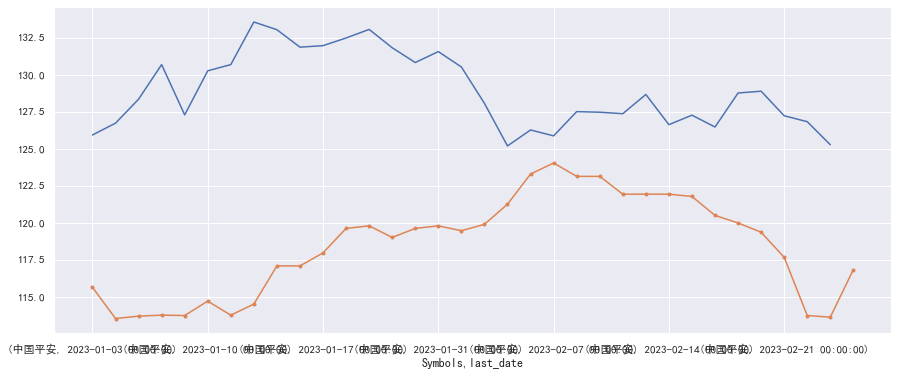

In [52]:
plt.figure(figsize=(15, 6))

y_test.plot(ax=plt.gca())
y_pred.plot(ax=plt.gca(), legend=None, marker=".")

# 参考
[1] [ML]tsfresh:时序数据特征自动提取工具, https://mp.weixin.qq.com/s/Pi5YIW2ywLbdoVkwZl0nVQ
[2] 时间序列学习 经典案例（1）【tsfresh】预测多只股票, https://blog.csdn.net/qq_42658739/article/details/122425952